# AcadGild_DataScience_ML_Assignemnt_32

<b> Objective </b> : To make ARIMA model over shampoo sales data and check the MSE between predicted and actual value.

In [ ]:
# Solution

#### Load python modules 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from pandas.tools.plotting import autocorrelation_plot
import warnings
from pandas import datetime , read_csv
warnings.filterwarnings('ignore')
%matplotlib inline


#### Load Dataset

DataSet has been dowloaded from 
https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-yearperiod#!ds=22r0&display=line
in .csv format.

In [2]:
## Function for parsing date in dataset into yyyy-mm-dd format 

def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [3]:
## Load dataset into  series object
series = read_csv('sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [4]:
# Sample rows of data
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64

#### Explporatory data analysis

In [5]:
# Statistical evaluation of data 

series.describe()

count     36.000000
mean     312.600000
std      148.937164
min      119.300000
25%      192.450000
50%      280.150000
75%      411.100000
max      682.000000
Name: Sales of shampoo over a three year period, dtype: float64

In [6]:
# Check for duplicate rows in data

series.duplicated().values.any()

False

In [7]:
# Get shape (structure ) of data

series.shape

(36,)

There is 36 rows in data

In [8]:
## Check for null rows in data

series.isnull().values.any()

False

In [9]:
# Indexes Of data

series.index

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01', '1901-11-01', '1901-12-01',
               '1902-01-01', '1902-02-01', '1902-03-01', '1902-04-01',
               '1902-05-01', '1902-06-01', '1902-07-01', '1902-08-01',
               '1902-09-01', '1902-10-01', '1902-11-01', '1902-12-01',
               '1903-01-01', '1903-02-01', '1903-03-01', '1903-04-01',
               '1903-05-01', '1903-06-01', '1903-07-01', '1903-08-01',
               '1903-09-01', '1903-10-01', '1903-11-01', '1903-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

#### Visual analysis

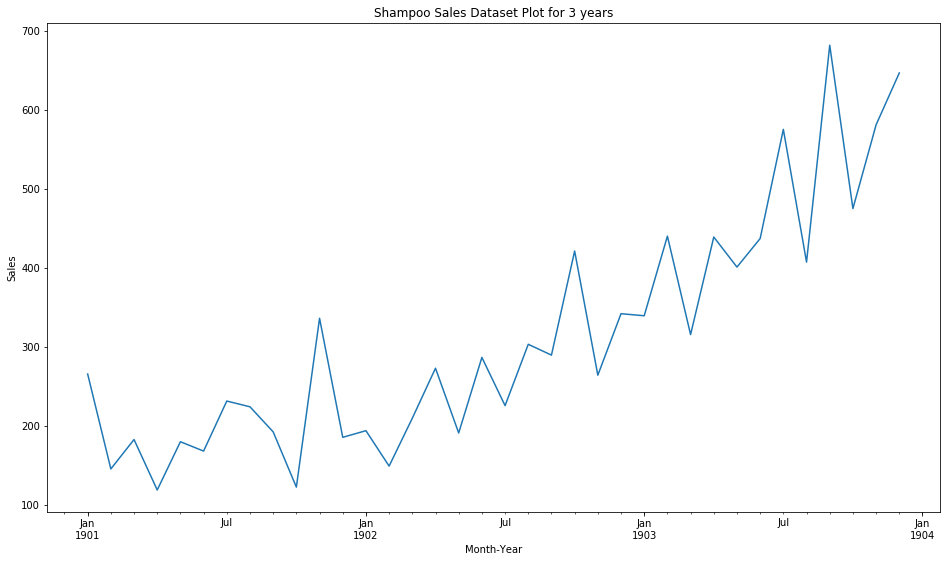

In [10]:
# Visual representation of data

series.plot(figsize=(16,9))
plt.title('Shampoo Sales Dataset Plot for 3 years')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.show()


It can be seen that with rise in years sales of sahmpoo's also getting gain with the time. There is an overall increasing trend in the data.

### Check for whether mentioned time series data is stationary or non-stationary


In order to check whether time series data is stationary or not , test like plotting rolling stattics test and dicker-fuller test can be done.

##### Plotting rolling statistics

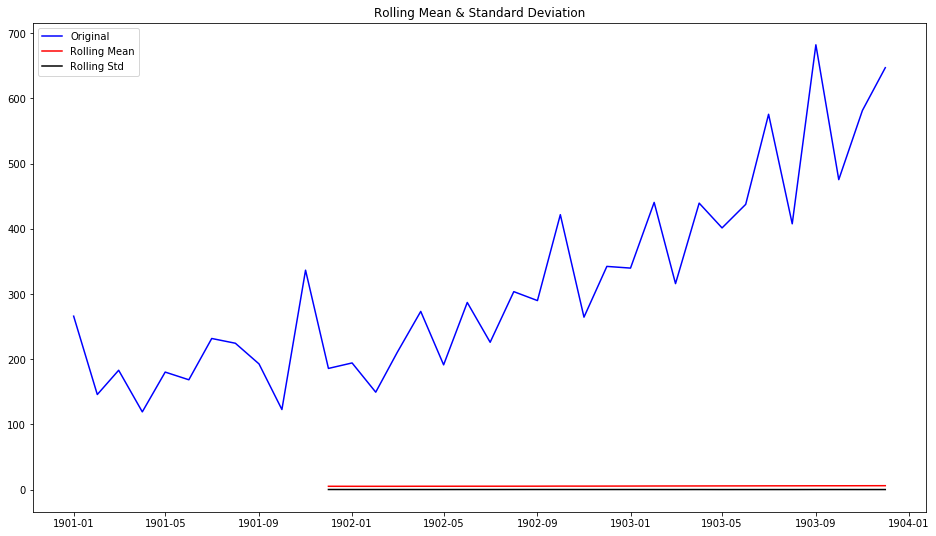

In [11]:
def test_stationarity_on_timeseries(timeseries):
    ''' This function plots statistical graph for time series data'''
    
    #Determing rolling statistics
    
    ts_log = np.log(timeseries)
    rolmean = ts_log.rolling(window=12).mean()
    rolstd = ts_log.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(16,9))
    orig = plt.plot(timeseries, color='blue',label='Original' )
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    
    
## Apply time series data on function
test_stationarity_on_timeseries(series)

As we can see that there is slight difference between rolling mean and standard devaition  with time as time series is non-stationary

#### Augmented dicker fuller test

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

In [12]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test_for_timeseries(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test_for_timeseries(series)

Results of Dickey-Fuller Test:
Test Statistic                  3.060142
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


As Test statistics is way more than critical value thus time series is not stationary

#### Correlation plot on time series data

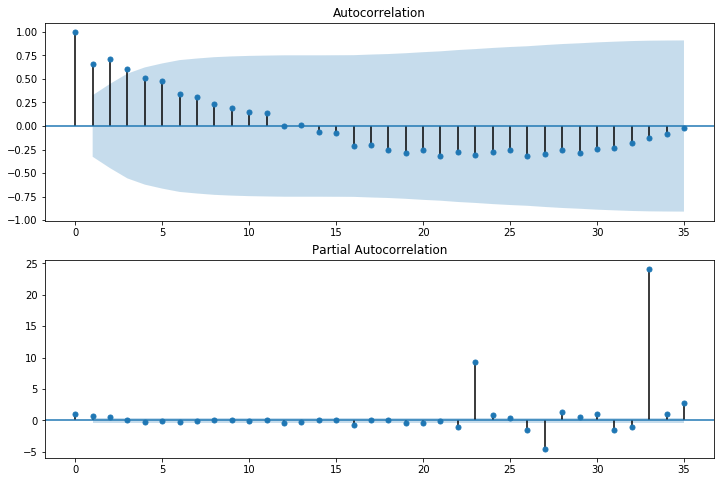

In [13]:
#Correlation plot using statsmodel

import statsmodels.api as sm

#Autocorrelation Plot

%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series.values.squeeze(), lags=35, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=35, ax=ax2)


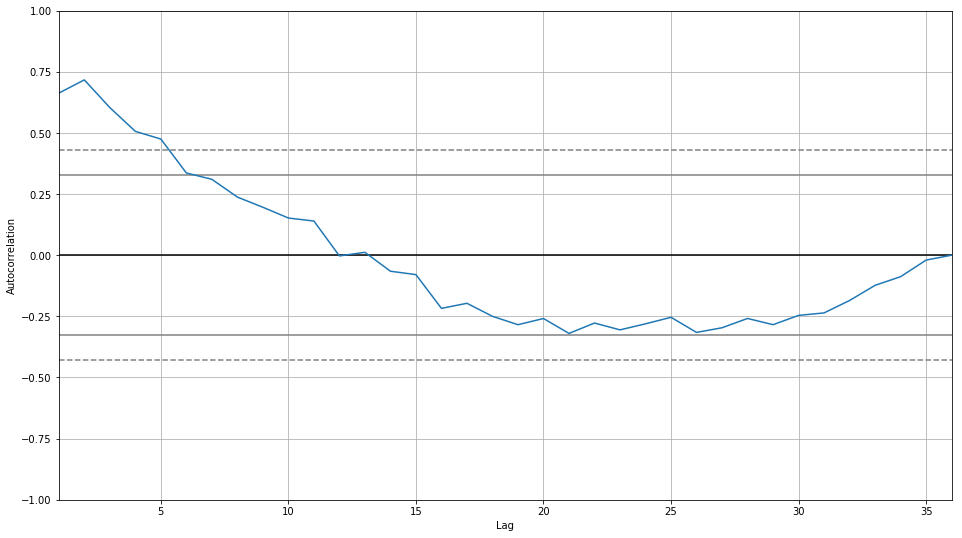

In [14]:
#Autocorrelation Plot Using Pandas
plt.figure(figsize=(16,9))
autocorrelation_plot(series)
plt.show()

we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.
A good starting point for the AR parameter of the model may be 7.

## ARIMA Modelling on time series data

ARIMA(p,d,q)

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

In [15]:
# Intializing ARIMA model

# fit an ARIMA(7,1,0) model. 
# This sets the lag value to 7 for autoregression, uses a difference order of 1 to make the time series stationary, 
# and uses a moving average model of 0.

arima_timeSeries_model = ARIMA(series , order=(7,1,0))

In [16]:
# fit the model

arima_timeSeries_model_fit = arima_timeSeries_model.fit(disp=0)  # to turn off the debug information provided by linear regression model, set the disp argument to 0.

In [17]:
# Model summary

print(arima_timeSeries_model_fit.summary())

                                          ARIMA Model Results                                          
Dep. Variable:     D.Sales of shampoo over a three year period   No. Observations:                   35
Model:                                          ARIMA(7, 1, 0)   Log Likelihood                -195.061
Method:                                                css-mle   S.D. of innovations             61.791
Date:                                         Mon, 24 Dec 2018   AIC                            408.121
Time:                                                 01:54:51   BIC                            422.119
Sample:                                             02-01-1901   HQIC                           412.953
                                                  - 12-01-1903                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

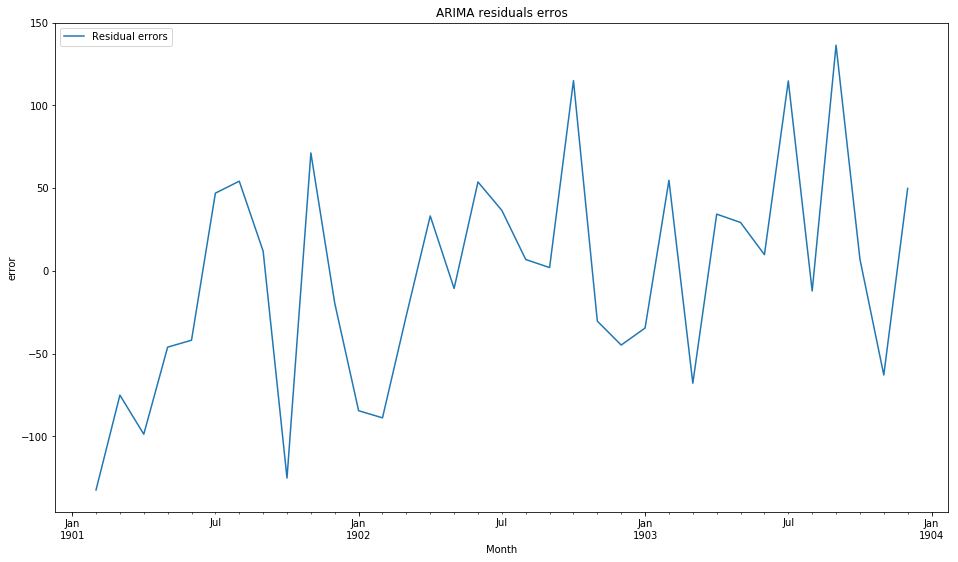

In [22]:
#Plots residual errors (Residual Error Line Plot)
arima_residuals = pd.DataFrame(arima_timeSeries_model_fit.resid , columns=['Residual errors'])
arima_residuals.plot(figsize=(16,9))
plt.ylabel("error")
plt.title('ARIMA residuals erros')
plt.show()

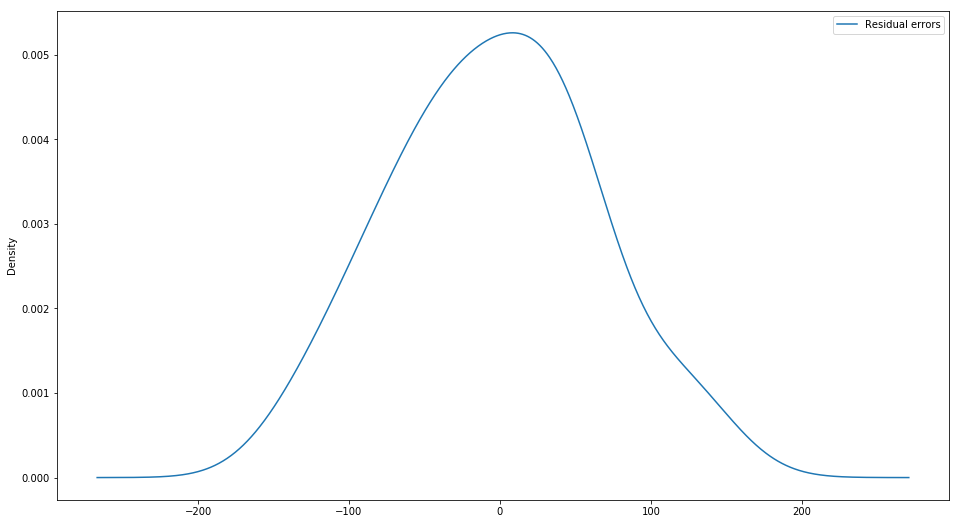

In [23]:
#Density Plot of the residual error values
arima_residuals.plot(kind='kde',figsize=(16,9) )
plt.show()

In [24]:
#The summary statistics of the residuals
print(arima_residuals.describe())

       Residual errors
count        35.000000
mean         -3.834191
std          66.314392
min        -132.418525
25%         -45.464299
50%           1.993619
75%          41.784341
max         136.428095


#### Predictions using ARIMA Model

In [25]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('Predicted=%f, Expected=%f' % (yhat, obs))

Predicted=349.117556, Expected=342.300000
Predicted=306.512948, Expected=339.700000
Predicted=387.376446, Expected=440.400000
Predicted=348.154141, Expected=315.900000
Predicted=386.308803, Expected=439.300000
Predicted=356.082046, Expected=401.300000
Predicted=446.379461, Expected=437.400000
Predicted=394.737311, Expected=575.500000
Predicted=434.915513, Expected=407.600000
Predicted=507.923346, Expected=682.000000
Predicted=435.482809, Expected=475.300000
Predicted=652.743808, Expected=581.300000
Predicted=546.343467, Expected=646.900000


##### Evaluation of Model

In [26]:
print('Test Mean Squared Error: %.2f' %  mean_squared_error(test, predictions))

Test Mean Squared Error: 6958.33


#### Visualising Actual vs predicted sales data

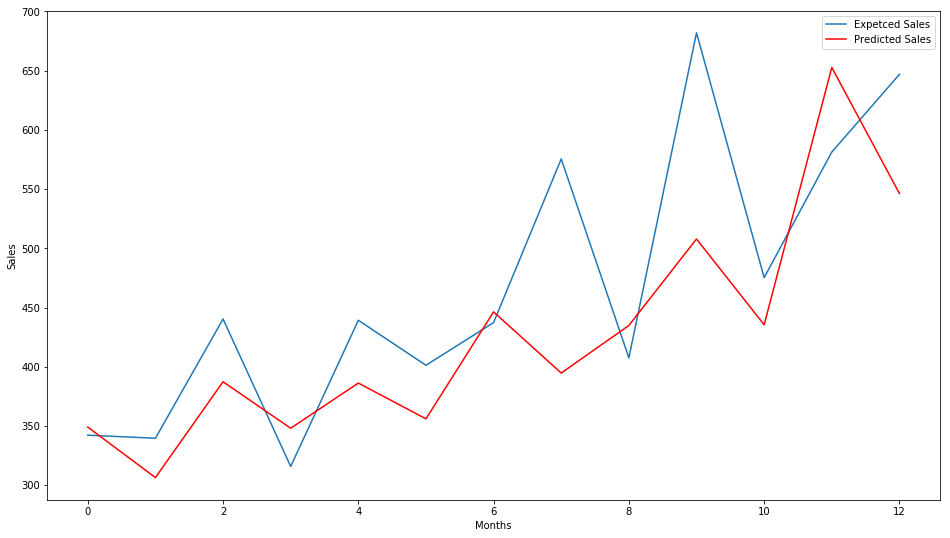

In [28]:
plt.figure(figsize=(16,9))
plt.plot(test , label='Expetced Sales')
plt.plot(predictions, color='red' , label='Predicted Sales')
plt.legend(loc='best')
plt.xlabel("Months")
plt.ylabel("Sales")
plt.show()